# 🌬️ Analyse av luftkvalitetsdata med NILU API
Denne notebooken dokumenterer hele arbeidsflyten for NILU-delen av prosjektet. Målet er å rense, transformere og visualisere luftkvalitetsdata (NO₂, O₃, SO₂) for bruk i senere analyse. 

### Datakilde: NILU API

**Kilde**: [api.nilu.no](https://api.nilu.no/)  
**Leverandør**: Norsk institutt for luftforskning (NILU)  
**Datakvalitet**: Høy – data fra offisielle målestasjoner  
**Tilgjengelighet**: Åpen (ingen API-nøkkel nødvendig for grunnleggende tilgang)  
**Brukervennlighet**: God, med REST-endepunkter og dokumentasjon

Valget av NILU API er basert på følgende kriterier:

- Kildeautoritet: NILU er en ledende institusjon innen luftkvalitetsforskning.
- Datakvalitet: Målinger fra sertifiserte og kalibrerte målestasjoner.
- Tilgjengelighet: Tilgjengelig for allmennheten uten behov for API-nøkkel.
- Brukervennlighet: Strukturert respons i JSON og fleksible parametere.

---

### ☁️ Henting og prosessering av luftkvalitetsdata (NILU API)

I denne delen av prosjektet benyttes **NILU API** for å hente luftkvalitetsdata for Oslo og nærliggende områder. Dataene struktureres og lagres i JSON-format.


#### Funksjonalitet

1. **Henting av luftkvalitetsdata**:
   - Geografisk område: Oslo
   - Koordinater: `59.9139`, `10.7522`
   - Radius: `20 km`
   - Periode: 2010-01-01 til 2016-04-02
   - Endepunkt: `https://api.nilu.no/stats/day/{from_date}/{to_date}/{latitude}/{longitude}/{radius}`
   - Rådata hentes ved hjelp av funksjonen `fetch_raw_data_niluAPI(endpoint) som håndterer API-kall

2. **Prosessering og lagring av data**:
   - Bearbeiding av JSON-respons
   - Dataene prosesseres med funksjonen `process_raw_data(data)`\
      - Dataene omstruktureres videre til en `pandas.DataFrame` med én rad per dato.
   - Kolonner i datasettet:
        - "Dato" (str)
        - "Dekningsgrad_NO2", "Dekningsgrad_O3", "Dekningsgrad_SO2"  (float)
        - "Verdi_NO2", "Verdi_O3", "Verdi_SO2" (float)

   - Strukturert dataeksport til:
     - Mappe: `../../data/raw_data/`
     - Filnavn: `raw_air_quality_nilu_oslo.json`

Som nevnt i Frost-delen av prosjektet er JSON et egnet format for lagring av værdata fordi det tilbyr et strukturert og lesbart format, er enkelt å integrere i Python-kode, fleksibelt og støtter komplekse datastrukturer som værdata.

#### Forutsetninger

- Python installert med nødvendige biblioteker: `requests`, `json`, `os`, `pathlib`
- Tilgang til [NILU API](https://api.nilu.no/)
- Skrivetilgang til katalogen: `../../data/raw_data/`

#### Videre prosess 
- De lagrede dataene kan enkelt lastes inn til pandas DataFrame for videre analyse ...
- Videre prosess inkluderer sikring av **datakvalitet** gjennom rensning av datasettet for å gi bedre grunnlag for pålitelige analyser. Vi ønsker å sikre at datasettet er fullstendig og et fravær av utliggere for å sikre god datakvalitet - dette er neste steg i arbeidsflyten. 

In [1]:
#Globale paramtere for niluAPI
import sys
import numpy as np
import pandas as pd
import pandasql as psql
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


#Parametere for niluAPI
base_url = "https://api.nilu.no/stats/day/"
from_date = "2010-04-02"
to_date = "2016-12-31"
radius=20

#Oslo kordinater
latitude= 59.9139
longitude=10.7522

##Filbane 
sys.path.insert(0, '../../src')

In [2]:
from data_niluAPI import get_raw_data_niluAPI
get_raw_data_niluAPI()

Gruppert data er lagret under ../../data/raw_data/raw_air_quality_nilu_oslo.json


---
### 🧼 Rensing og klargjøring av NILU-data

Denne delen av prosjektet håndterer rensing og forbedring av luftkvalitetsdata hentet fra **NILU API**. Fokus ligger på å fjerne uteliggere, interpolere manglende data, og korrigere skjevheter i datafordelingen for å gjøre datasettet klarere og mer pålitelig for videre analyser.

#### Funksjonalitet

##### Fjerning av outliers og interpolering

- Leser rådata fra JSON-fil.
- Fjerner outliers på utvalgte gasser: `Verdi_NO2`, `Verdi_O3`, `Verdi_SO2`.
- Interpolerer manglende verdier for å opprettholde kontinuerlig dataserie.
- Lagrer renset data som JSON-fil.

##### `clean_data_niluAPI()`

| Funksjon                         | Beskrivelse                                                                                     |
|---------------------------------|------------------------------------------------------------------------------------------------|
| **Laster inn rådata**            | Leser rådata fra `raw_air_quality_nilu_oslo.json`.                                             |
| **Fjerner outliers**             | Kaller `remove_outliers` for å identifisere og sette ekstremverdier til `NaN`.                   |
| **Interpolerer manglende verdier** | Bruker `interpolate_data` for å fylle inn manglende verdier i tidsserien.          |




Resultatet av rensningen skal være et komplett datasett med høyere datakvalitet. Ekstreme verdier skal være fjernet og erstattet med realistiske interpolerte estimater.


#### Skjevhetskorreksjon av data

- Analyserer datasett for skjevhet i fordeling.
- Bruker Yeo-Johnson transformasjon for å normalfordele variablene.
- Lagrer korrigerte data for videre analyse.


#### Forutsetninger

- Rådata må være tilgjengelig i: `../../data/raw_data/raw_air_quality_nilu_oslo.json`
- Python-moduler fra prosjektmappen må være importert.
- Krever `sys` for path-håndtering og tilgang til spesialfunksjoner.
- Resultater lagres i:
  - Renset data: `../../data/clean_data/niluAPI_clean_data.json`
  - Analysert data: `../../data/analyzed_data/niluAPI_analyzed_data.json`


Fjerning av outliers:
Outliers er mer enn 3 standardavvik unna gjennomsnittet

Verdi_NO2:
Fjernet 39 outliers
Standardavvik: 21.74
Gjennomsnitt: 32.25

Antall manglende verdier per kolonne:
Dato                  0
Dekningsgrad_NO2      6
Dekningsgrad_O3     378
Dekningsgrad_SO2    178
Verdi_NO2            45
Verdi_O3            378
Verdi_SO2           178
dtype: int64


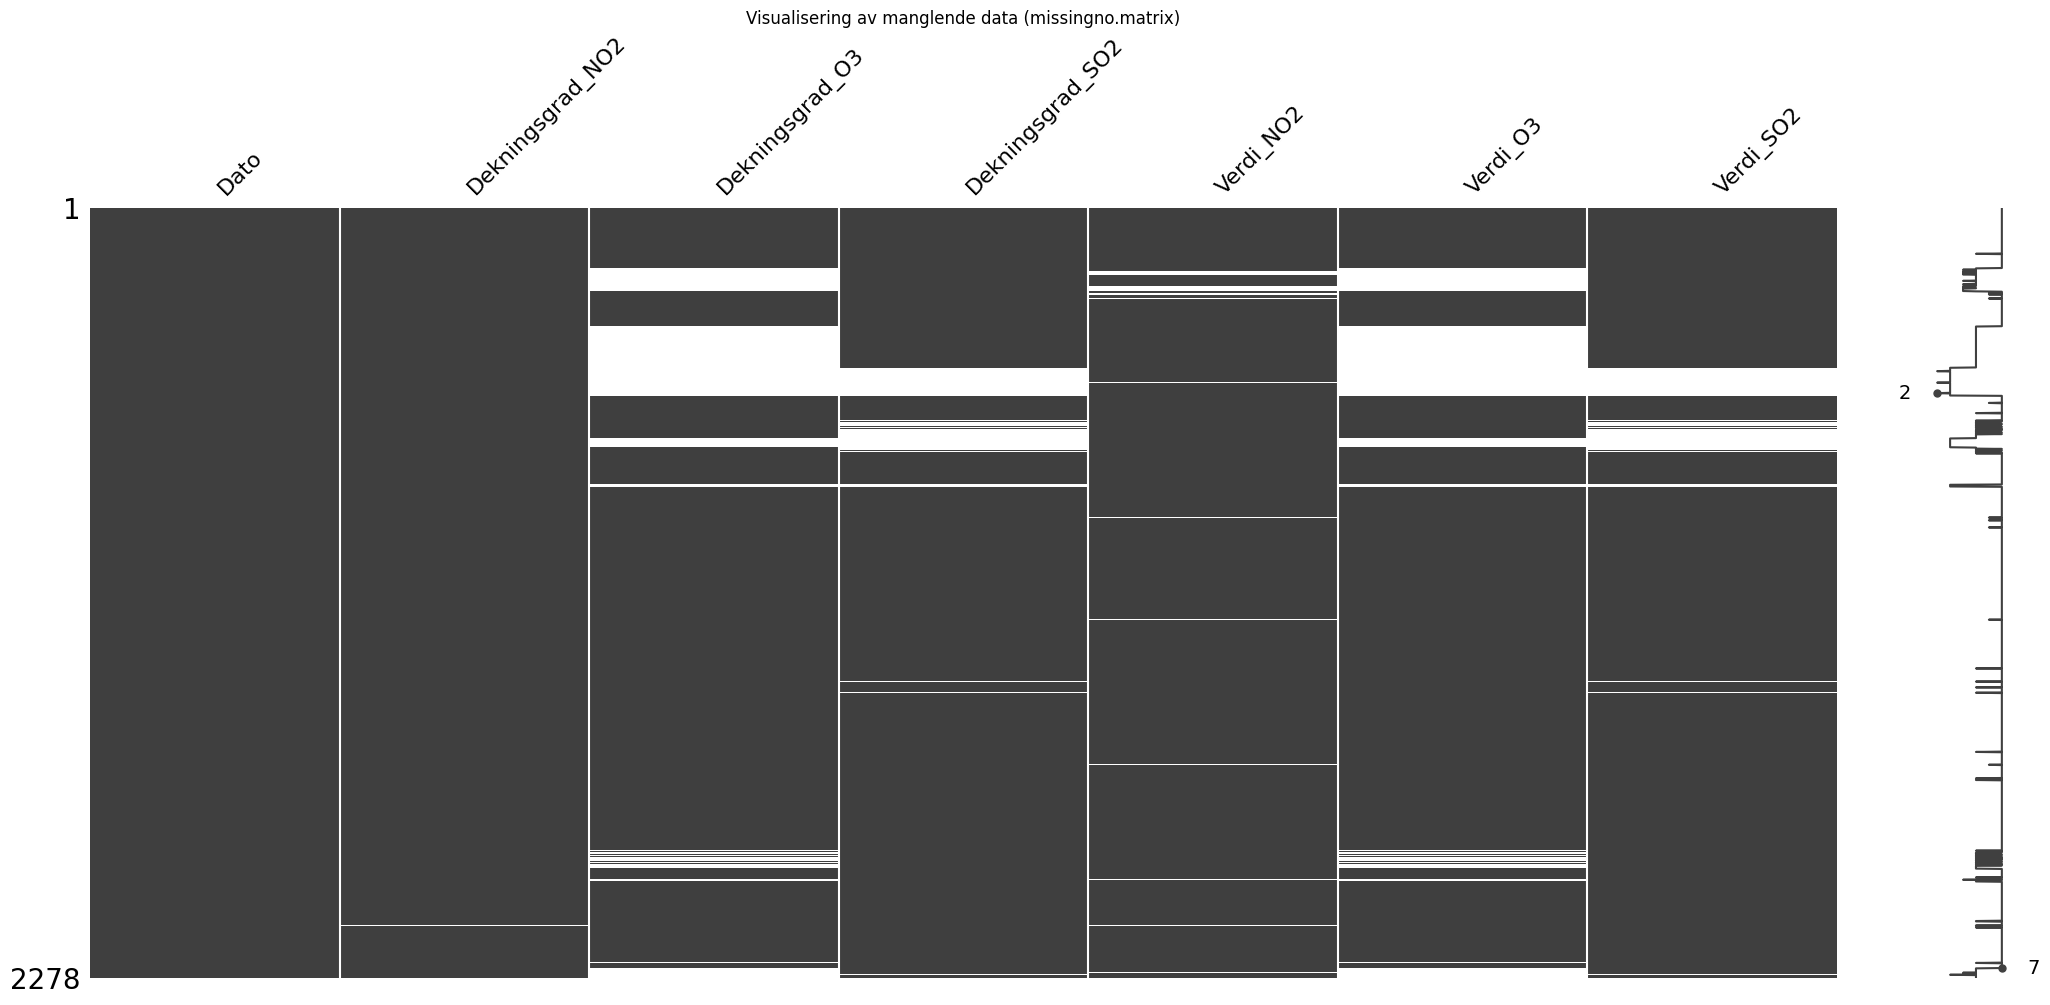

Verdi_O3:
Fjernet 8 outliers
Standardavvik: 16.29
Gjennomsnitt: 42.08

Antall manglende verdier per kolonne:
Dato                  0
Dekningsgrad_NO2      6
Dekningsgrad_O3     378
Dekningsgrad_SO2    178
Verdi_NO2            45
Verdi_O3            386
Verdi_SO2           178
dtype: int64


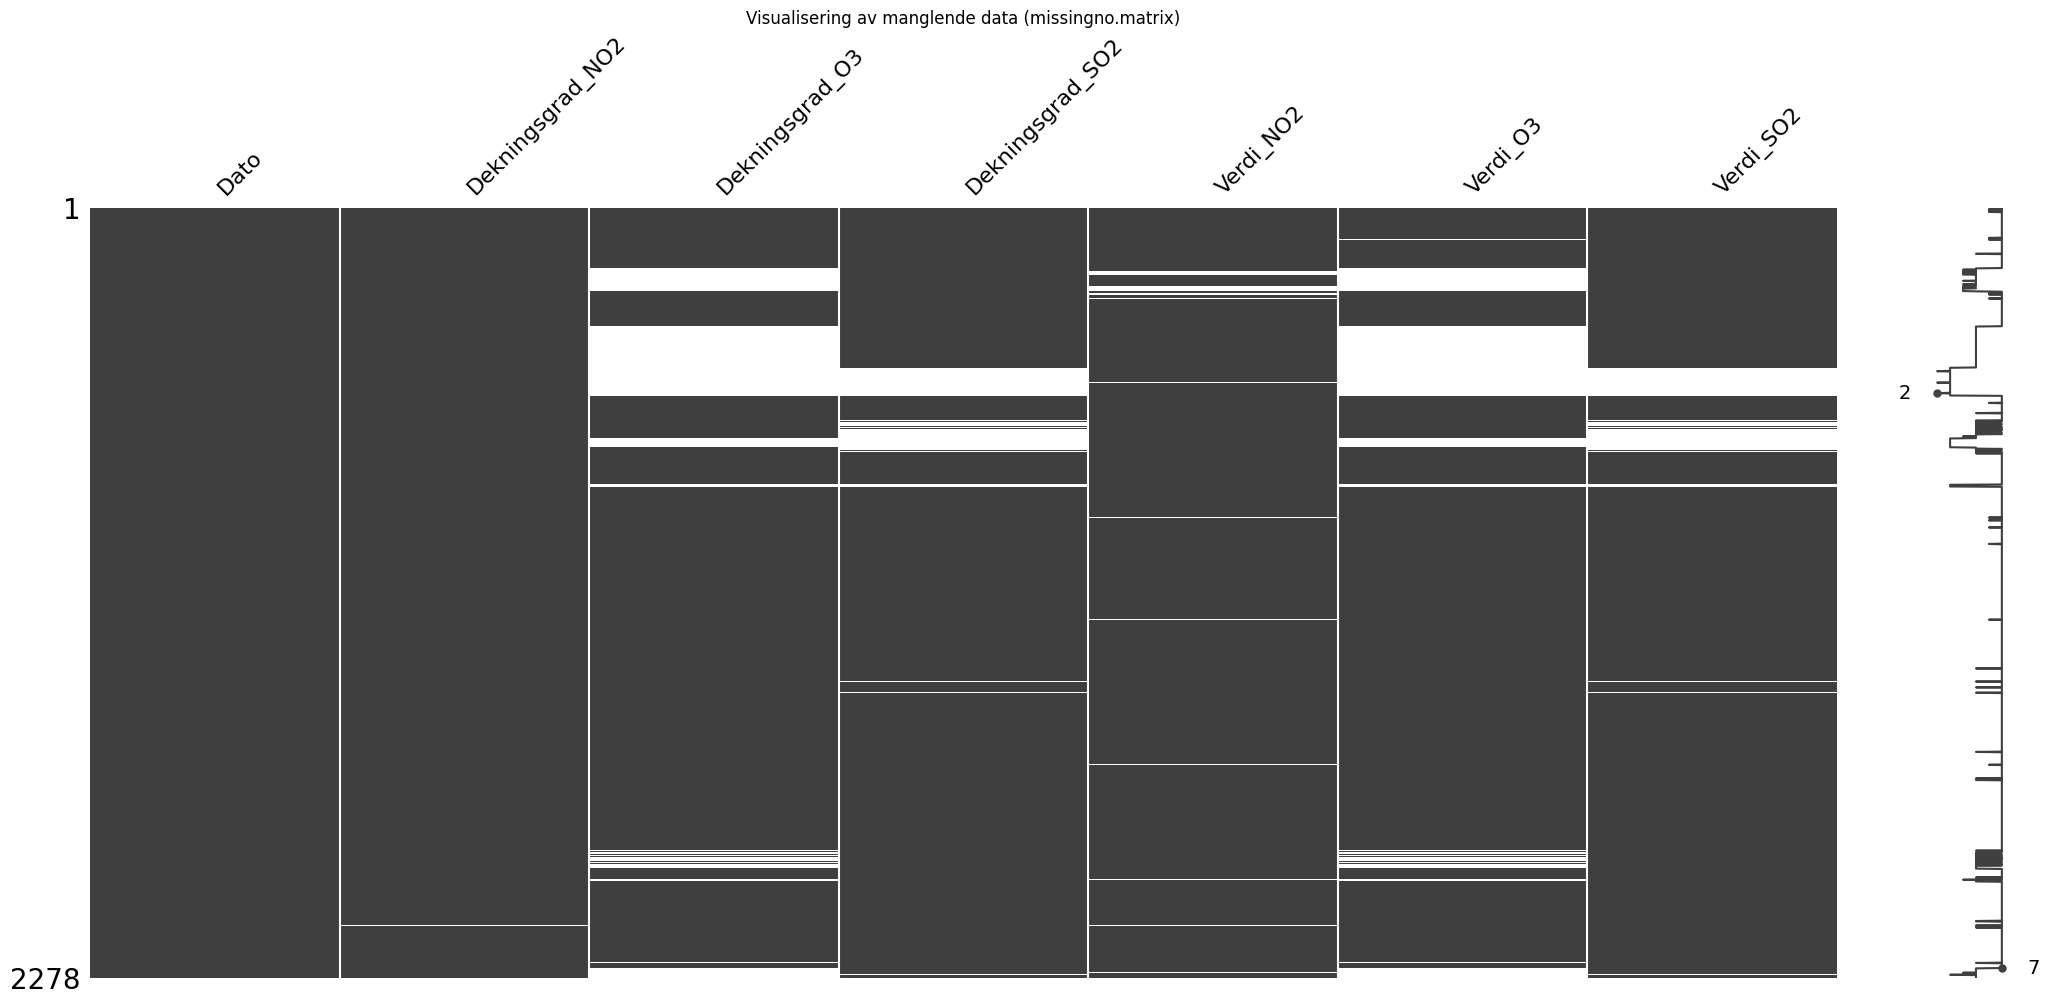

Verdi_SO2:
Fjernet 27 outliers
Standardavvik: 1.17
Gjennomsnitt: 2.23

Antall manglende verdier per kolonne:
Dato                  0
Dekningsgrad_NO2      6
Dekningsgrad_O3     378
Dekningsgrad_SO2    178
Verdi_NO2            45
Verdi_O3            386
Verdi_SO2           205
dtype: int64


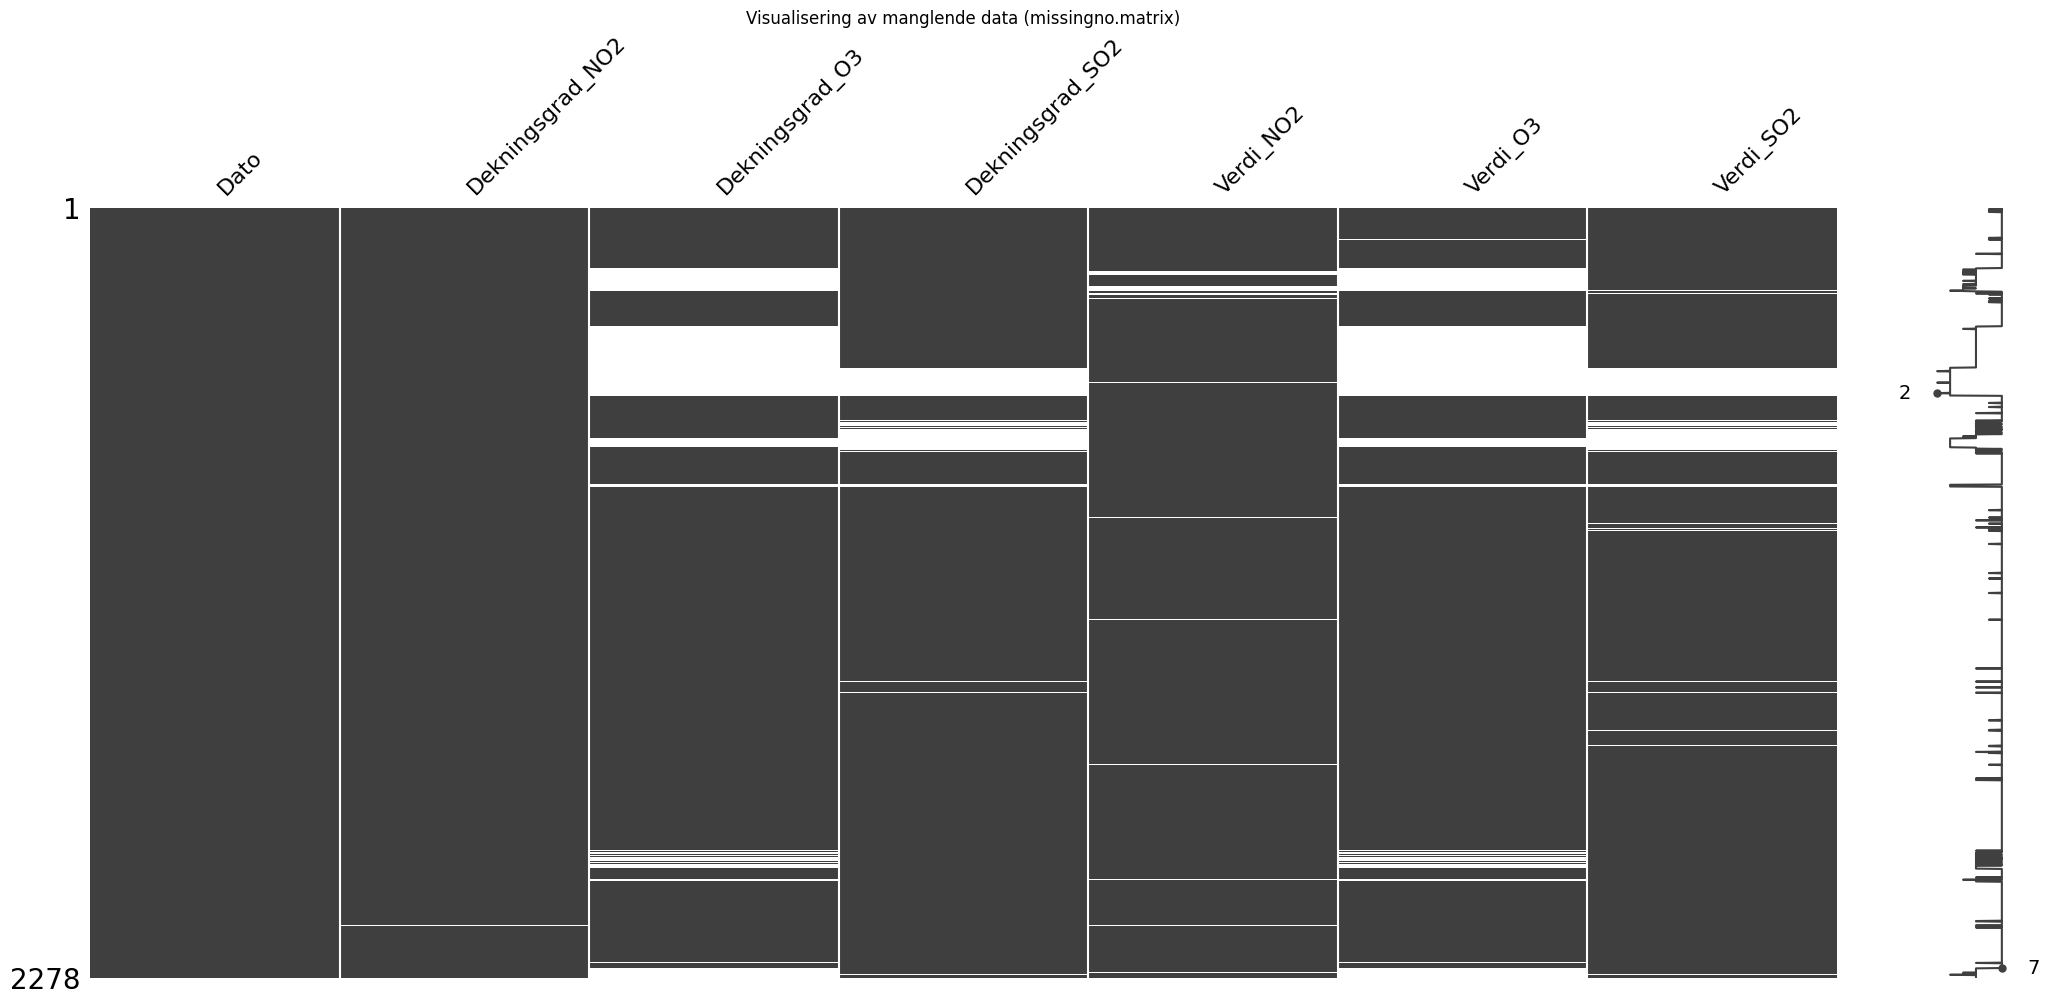


Interpolering av NaN-verdier:
Verdi_NO2: 233 verdier ble interpolert
Verdi_O3: 574 verdier ble interpolert
Verdi_SO2: 393 verdier ble interpolert

Renset data er lagret under ../../data/clean_data/niluAPI_clean_data.json


In [3]:
from data_niluAPI import clean_raw_data
clean_raw_data()

In [4]:
from data_niluAPI import fix_skewness_data_niluAPI
fix_skewness_data_niluAPI()

Skjevhet før transformasjon:
→ Verdi_NO2: 1.12
→ Verdi_O3: -0.18
→ Verdi_SO2: 0.76

Behandler kolonner med skjevhet over ±1.0:

Verdi_NO2: skjevhet 1.12 → Yeo-Johnson + skalering
Verdi_O3: skjevhet -0.18 → kun skalering
Verdi_SO2: skjevhet 0.76 → kun skalering

Skjevhet etter transformasjon:
→ Verdi_NO2_Trans: -0.01
→ Verdi_O3_Trans: -0.18
→ Verdi_SO2_Trans: 0.76

Transformert data lagret i: ../../data/analyzed_data/niluAPI_analyzed_data.json


---
## 📊  Analyse av luftkvalitetsdata fra NILU API (2010-2016)
I denne delen analyseres luftkvalitetsdata for Oslo over en seksårsperiode (2010-2016), hentet fra NILU API. Hensikten er å avdekke trender, sesongvariasjoner og potensielle forbedringer eller forverringer i luftkvaliteten over tid. Dataene inkluderer konsentrasjoner av NO₂, O₃ og SO₂, som er blant de viktigste indikatorene på lokal luftforurensning.

#### Metoder brukt for analyse:
- Pandas – brukt for datarensing, konvertering av datoer, og sammenstilling av datasett med flere kolonner for luftkvalitet og dekningsgrad.
- Plotly (graph_objects) – benyttet til å lage interaktive grafer som gjør det mulig å identifisere trender og vurdere datakvalitet visuelt.
- Fargekoding etter datakvalitet –  gir en visuell indikator på datanes pålitelighet.
- Trendlinjeanalyse – indikere utviklingen over tid for hver luftforurensningskomponent.

Alle analyser ledsages av visualiseringer, og resultatene tolkes med tanke på mulige miljø- og samfunnsmessige årsaker. Datasettet er renset og korrigert for skjevhet for å sikre robusthet i analysene.

### Visualisering av luftkvalitet og datakvalitet

#### Hva gjør funksjonen?
Funksjonen `plot_air_quality()` genererer separate grafer for ulike luftforurensningskomponenter (NO₂, O₃, SO₂). Hver graf viser:

- En **punktsky** av måleverdier over tid.
- En **blå trendlinje** som indikerer utviklingen.
- **Fargekoding** av datapunkter basert på datakvalitet:
  - 🔴 **Rød** – manglende eller interpolerte verdier  
  - 🟡 **Gul** – dekningsgrad under 90 %  
  - 🟢 **Grønn** – god datakvalitet (≥ 90 %)

#### Fordeler ved denne fremstillingsmåten
- **Tydelig kommunikasjon av datakvalitet:** Brukeren får umiddelbar visuell informasjon om hvilke data som er pålitelige.
- **Støtter tolkning av trender:** Trendlinjer hjelper med å identifisere mønstre over tid.
- **Fleksibel og gjenbrukbar struktur:** Funksjonen tar generelle parametere og kan brukes på andre variabler, stasjoner og tidsperioder.
- **Styrker datadrevne beslutninger:** Fremhever både verdier og usikkerheter, noe som er avgjørende for miljøanalyse og -rapportering.

#### Relevans og Anvendelse
Denne funksjonen er sentral i å visualisere endringer i luftkvalitet over tid, og demonstrerer effektiv bruk av **interaktive visualiseringer** for å kommunisere både måleverdier og datakvalitet. Gjennom fargekoding av datapunkter gir grafene ikke bare innsikt i luftforurensning, men også i påliteligheten til datagrunnlaget.

Visualiseringene gir følgende fordeler og anvendelser:

- **Formidling av datakvalitet:** Brukeren ser umiddelbart hvilke målinger som er komplette, delvis mangelfulle eller interpolerte.
- **Overvåking og miljøanalyse:** Egnet for både forskningsformål og offentlig rapportering.
- **Beslutningsstøtte:** Kan brukes som verktøy i politikkutforming og miljøtiltak.
- **Tilgjengelighet for publikum:** Plotly gir interaktivitet som lar brukeren utforske dataene selv.






In [5]:
from data_niluAPI import load_and_plot_air_quality
load_and_plot_air_quality()

## Analyse av *månedlig* luftkvalitet i Oslo (2010-2016)

Grafen over viser utviklingen i gjennomsnittlig månedlig konsentrasjon av NO₂ (nitrogendioksid), O₃ (ozon) og SO₂ (svoveldioksid) i Oslo over perioden 2010 til 2016. Dataene er aggregert per måned. 

### Observasjoner:

- **NO₂ (blå linje)**:
  - Har tydelig sesongvariasjon med høyere verdier om vinteren og lavere om sommeren.

- **O₃ (oransje linje)**:
  - Viser et motsatt mønster sammenlignet med NO₂: høyere verdier om sommeren og lavere om vinteren.
  - Dette skyldes at ozon dannes i atmosfæren ved hjelp av sollys, og nivåene øker derfor i de lysere månedene.

- **SO₂ (grønn linje)**:
  - Har svært lave og stabile verdier i hele perioden.
  - Dette tyder på at utslippene av svoveldioksid er lave og godt regulert i Oslo.


Luftkvaliteten i Oslo viser klare sesongmessige mønstre for NO₂ og O₃. NO₂ er høyest om vinteren, mens O₃ dominerer om sommeren som følge av fotokjemiske reaksjoner. SO₂-nivåene er lave gjennom hele perioden, noe som antyder at det ikke er en stor lokal kilde til dette forurensningsstoffet. Den totale utviklingen antyder at det kan være hensiktsmessig å innføre tiltak for å redusere NO₂, spesielt i vintermånedene.

#### Fordeler ved denne fremstillingsmåten
- **Tydelig visualisering av tidsutvikling**: Linjediagrammet viser klart hvordan verdiene endrer seg måned for måned. 
- **Enkelt å oppdage sesongvariasjoner**: Diagrammet gjør det lett å se sesongmønstre.
- **Sammenligning av flere komponenter**: Flere komponenter kan vises i samme diagram, noe som gjør det enkelt å sammenligne nivåene og oppdage samspill.
- **Intuitivt**: Ved bruk av ulike farger er diagrammet enkelt å forstå og tolke både for eksperter og ikke-eksperter. 


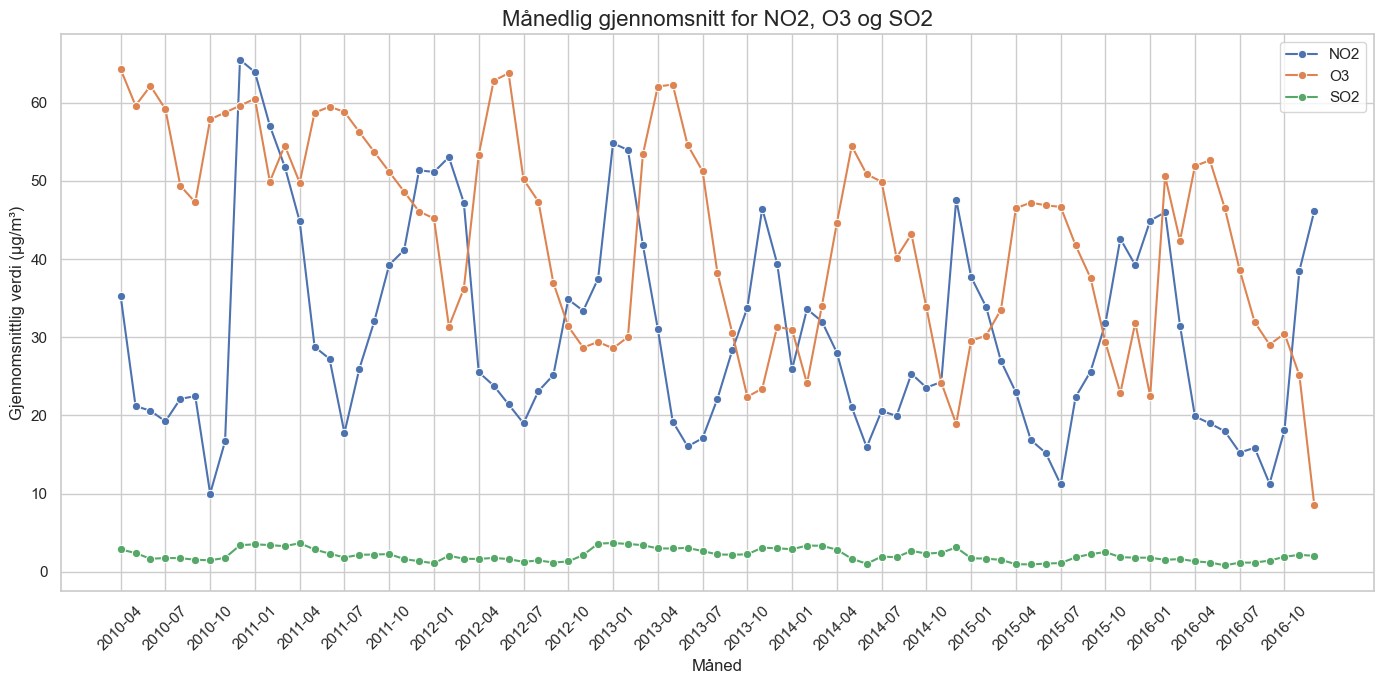

In [6]:
from sql_analysis import analyze_monthly_avg_nilu_data
monthly_stats = analyze_monthly_avg_nilu_data()

---
[⬅️ Forrige: Frost-analyse](../frostAPI/frostAPI.ipynb)                    
[➡️ Neste: Kombinert analyse](../Kombinert_analyse.ipynb) 